In [134]:
# return subscript number or text as a string
def sub(Input):
    return r'$_{'+str(Input)+'}$'

# return superscript number or text as a string
def sup(Input):
    return r'$^{'+str(Input)+'}$'

In [135]:
#MUSCLES data type selection

#get a drop down menu
import ipywidgets as widgets
Data_Type_List = ['Constant native resolution','Variable native resolution','Constant adaptive resolution','Variable adaptive resolution']

#select data type from MUSCLES files
data_type = widgets.Dropdown(options=(Data_Type_List),description='Data type selection',disabled=False)
display(data_type)

Dropdown(description='Data type selection', options=('Constant native resolution', 'Variable native resolution…

In [136]:
'''
program options begin here
List of MUSCLES database below
'''

#reads in json files for MUSCLES data 
import json

if (data_type.value == 'Constant adaptive resolution'): 
    stellar_names_const_adapt_json = open('stellar_names_const_adapt.json')
    stellar_names_and_data = json.load(stellar_names_const_adapt_json)
elif (data_type.value == 'Constant native resolution'): 
    stellar_names_const_native_json = open('stellar_names_const_native.json')
    stellar_names_and_data= json.load(stellar_names_const_native_json)
elif (data_type.value == 'Variable adaptive resolution'): 
    stellar_names_var_adapt_json = open('stellar_names_var_adapt.json')
    stellar_names_and_data = json.load(stellar_names_var_adapt_json)
elif  (data_type.value == 'Variable native resolution'):
    stellar_names_var_native_json = open('stellar_names_var_native.json')
    stellar_names_and_data = json.load(stellar_names_var_native_json)

#get a drop down menu
import ipywidgets as widgets
#select directories for MUSCLES files
MUSCLES_files = widgets.Dropdown(options=(stellar_names_and_data),description='MUSCLES Files:',disabled=False)
display(MUSCLES_files)

Dropdown(description='MUSCLES Files:', options={'GJ 1132': 'https://archive.stsci.edu/missions/hlsp/muscles/gj…

In [137]:
'''
set Spectra_name_same_as_host_name = False if looking at exoplanets around
a different star to the ones in the MUSCLES database
i.e you want spectra for an M8 star but the closest spectra availiable is TRAPPIST-1
otherwise in this example you will only be able to select TRAPPIST-1 planets 
if Spectra_name_same_as_host_name = True
'''
Spectra_name_same_as_host_name = True
#get star name
star_name = [k for k, v in stellar_names_and_data.items() if v == MUSCLES_files.value][0]

In [138]:
# Import MUSCLES spectra
import os
if(os.path.isfile(MUSCLES_files.value)): print('File already downloaded')
else:os.system('wget '+ MUSCLES_files.value)

--2022-06-11 14:21:35--  https://archive.stsci.edu/missions/hlsp/muscles/gj1132/hlsp_muscles_multi_multi_gj1132_broadband_v23_const-res-sed.fits
Resolving archive.stsci.edu (archive.stsci.edu)... 130.167.201.60
Connecting to archive.stsci.edu (archive.stsci.edu)|130.167.201.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13538880 (13M) [allicashion/octet-stream]
Saving to: ‘hlsp_muscles_multi_multi_gj1132_broadband_v23_const-res-sed.fits’

     0K .......... .......... .......... .......... ..........  0%  615K 21s
    50K .......... .......... .......... .......... ..........  0% 1.16M 16s
   100K .......... .......... .......... .......... ..........  1% 1.18M 14s
   150K .......... .......... .......... .......... ..........  1% 93.0M 11s
   200K .......... .......... .......... .......... ..........  1% 16.5M 9s
   250K .......... .......... .......... .......... ..........  2% 1.29M 9s
   300K .......... .......... .......... .......... ..........  2% 

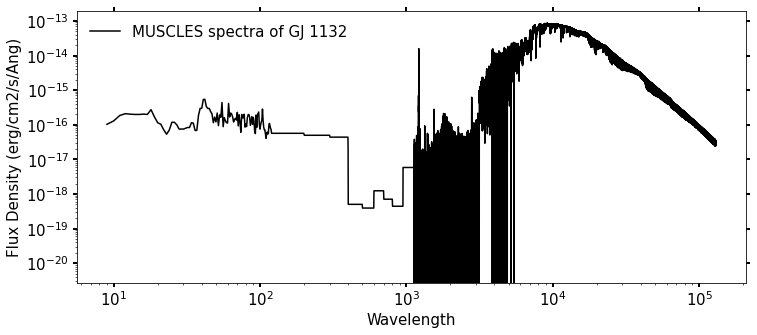

In [139]:
spec = fits.getdata(MUSCLES_files.value,1)
plt.figure(figsize = (12,5))
plt.plot(spec['WAVELENGTH'],spec['FLUX'], color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density (erg/cm2/s/Ang)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [140]:
#convert to mW/m2/nm
per_cm2_to_per_m2 = 100**2
erg_per_s_to_mW = 1e-4
per_Ang_to_per_nm = 10
New_flux = spec['FLUX'] * erg_per_s_to_mW * per_cm2_to_per_m2 * per_Ang_to_per_nm
# may need to change for different models
Wavelength = spec['WAVELENGTH']/10
plot_Wavelength = spec['WAVELENGTH']/10

In [141]:
#remove MUSCLES files in current directory
os.system('rm *muscles*.fits')

0

In [142]:
#Select climate model
Climate_model_list = ['WACCM','CAM','ExoCam','UM','ROCKE-3D','CCSM3','Atmos','ExoPrime','Custom grid']
Climate_model_selection = widgets.Dropdown(options=Climate_model_list,description='Select climate model',disabled=False)
display(Climate_model_selection)

Dropdown(description='Select climate model', options=('WACCM', 'CAM', 'ExoCam', 'UM', 'ROCKE-3D', 'CCSM3', 'At…

In [159]:
#Compare to WACCM standard solar file
Irradiance_at_Earth = 1360000
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    #check for file. Download if not in directory
    if(os.path.isfile('SolarForcingCMIP6piControl_c160921.nc')): print('File already downloaded')
    else: os.system('wget https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc --no-check-certificate')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file

    ds = xr.open_dataset(solar_file)#attach file to dataset
    ssi = ds['ssi'].isel(time=0) #define dataset from file
    model_flux = ssi.values #flux values
    model_wavelength = ssi.wavelength.values #wavelength grid
    starlabel = 'Sun' #label for plot
    Irradiance_at_Earth = 1360000
    
elif(Climate_model_selection.value == 'ExoCAM'):
    print('ExoCam spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'UM'):
    print('UM spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'ROCKE-3D'):
    #check for file. Download if not in directory
    if(os.path.isfile('sun')): print('File already downloaded')
    else: os.system('wget https://portal.nccs.nasa.gov/GISS_modelE/ROCKE-3D/stellar_spectra/sun')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file
    ROCKE_3D_solar_input = np.genfromtxt('sun', skip_header = 5, skip_footer = 1)
    model_flux = ROCKE_3D_solar_input[:,1]
    model_wavelength =  ROCKE_3D_solar_input[:,0]*1e9 #wavelength grid
    starlabel = 'Sun' #label for plot
    Irradiance_at_Earth = 1360 #in units of Wm^-2
    Wavelength = Wavelength*1e-9 #convert to m
    
elif(Climate_model_selection.value == 'CCSM3'):
    print('CCSM3 spectrum input file unknown') 
    
elif(Climate_model_selection.value == 'Atmos'):
    if(os.path.isfile('muscles_gj667c.txt')): print('File already downloaded')
    else: os.system('wget https://raw.githubusercontent.com/VirtualPlanetaryLaboratory/atmos/master/PHOTOCHEM/DATA/FLUX/muscles_gj667c.txt')
    ATMOS_gj667c_input = np.genfromtxt('muscles_gj667c.txt')
    model_wavelength = ATMOS_gj667c_input[:,0]/10
    model_flux = ATMOS_gj667c_input[:,1]
    starlabel = 'GJ 667 C'
else:
    print('Spectrum input file unknown')

File already downloaded


Total stellar irradiance relative to the Sun: 6.9490896852741555e-22
Scaled total stellar irradiance relative to the Sun: 0.9999999999999994


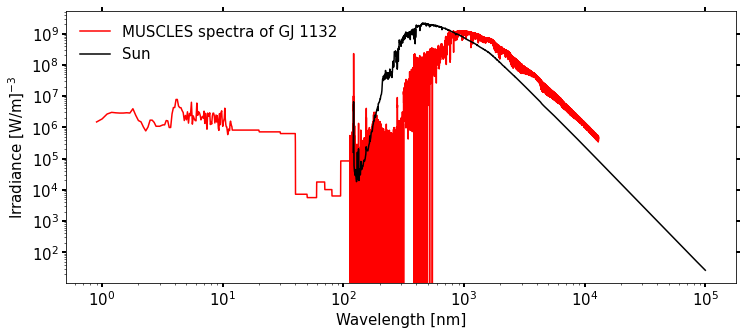

In [160]:
#find total stellar irradiance from file
from scipy.integrate import trapz
#get total stellar irradiance at top of atmosphere

TSI_spectra = trapz(New_flux, Wavelength)
print('Total stellar irradiance relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

# scale TSI
Scaled_flux_to_Earth = New_flux/(TSI_spectra/Irradiance_at_Earth)
TSI_spectra = trapz(Scaled_flux_to_Earth, Wavelength)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

#compare spectra to Sun
plt.figure(figsize = (12,5))
plt.plot(plot_Wavelength, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
plt.plot(model_wavelength, model_flux, color = 'k', label = starlabel)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Irradiance [W/m]'+sup(-3), fontsize = 15); plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [161]:
1/(TSI_spectra/Irradiance_at_Earth)

1.0000000000000007

In [162]:
import pandas as pd
#NASA_Exo_Archive = pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv')
NASA_Exo_Archive = pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,st_lum,pl_orbsmax,st_teff,rowupdate+from+ps&format=csv')

/tmp/ipykernel_83/512134744.py:2: DtypeWarning: Columns (50,65,148,153,183,187,206,211,237,242) have mixed types. Specify dtype option on import or set low_memory=False.
  NASA_Exo_Archive = pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv')


In [236]:
#Find planets based on host name
if (Spectra_name_same_as_host_name == True):
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == star_name]['pl_name']
    Find_planets = widgets.Dropdown(options=planets.drop_duplicates(),description='Find planets',disabled=False)
    display(Find_planets)
else:
    Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates()),description='Find host',disabled=False)
    display(Find_host)
    
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == Find_host.value]['pl_name']
    Find_planets = widgets.Dropdown(options=planets,description='Find planets',disabled=False)
    display(Find_planets)

Dropdown(description='Find planets', options=('GJ 1132 b', 'GJ 1132 c'), value='GJ 1132 b')

In [247]:
#drop nan rows for luminosity and orbital period
pl = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value].dropna(subset='st_lum')
pl = pl.dropna(subset='pl_orbsmax')

#find semi-major axis in AU
pl = pl.sort_values(by=['rowupdate'])
semi_major_axis = pl['pl_orbsmax'].iloc[-1]
print('semi-major axis of '+Find_planets.value+' = '+str(semi_major_axis)+' AU')

#find solar luminosity relative to Sun
stellar_luminosity = 10**pl['st_lum'].iloc[-1]
print('Star has '+str(stellar_luminosity)+ ' times luminosity of Sun')

#find the flux recieved relative to Earth
flux_recieved_relative_to_Earth = stellar_luminosity/(semi_major_axis**2)
print(Find_planets.value+' recieves '+str(flux_recieved_relative_to_Earth)+ ' times flux recieved by Earth')

semi-major axis of GJ 1132 b = 0.0153 AU
Star has 0.004375221051582521 times luminosity of Sun
GJ 1132 b recieves 18.690337270205994 times flux recieved by Earth


In [238]:
#download spectres
!pip install spectres
#import spectres 
import spectres as sp

#get maximum and minimum wavelength regions
min_wav = np.argmin(abs(Wavelength-model_wavelength[0]))
max_wav = np.argmin(abs(plot_Wavelength[-1]-model_wavelength))

TSI_spectra_muscles = trapz(Scaled_flux_to_Earth[min_wav:], Wavelength[min_wav:])
print(TSI_spectra_muscles)
new_wav_grid = model_wavelength[:max_wav]
New_grid_flux = sp.spectres(new_wav_grid, plot_Wavelength, Scaled_flux_to_Earth, spec_errs=None)
TSI_spectra_model = trapz(New_grid_flux, new_wav_grid)
print(TSI_spectra_model)

print(TSI_spectra_muscles/TSI_spectra_model)

# rescale to planet
Initial_scaled_flux = New_grid_flux * flux_recieved_relative_to_Earth
TSI_spectra = trapz(Initial_scaled_flux, new_wav_grid)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/Irradiance_at_Earth))

0.0
1359917899482.9976
0.0
Scaled total stellar irradiance relative to the Sun: 18689208971.41715


(10, 100000.0)

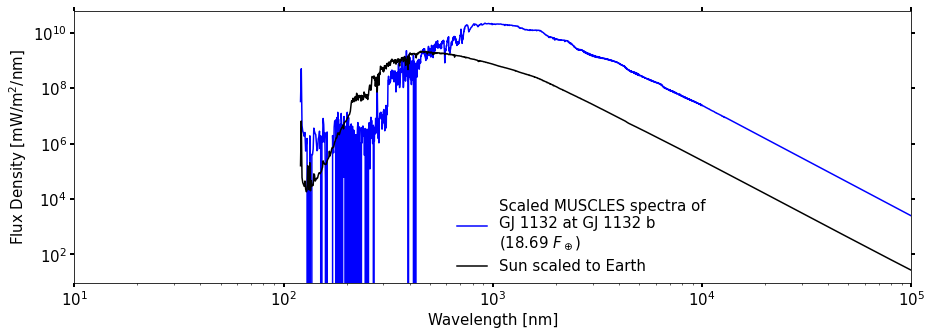

In [248]:
#Extend spectra using Raleigh Jeans Law
#add in functionality with PHOENIX for later
k = 1.381e-23
c = 299792458
T = pl['st_teff'].iloc[-1]
scaling = Initial_scaled_flux[max_wav-1]
RJL = 2*c*k*T/((model_wavelength[max_wav]*1e-9)**4)

IR_scaling = scaling/RJL
RJL_scaling = (IR_scaling)*(2*c*k*T/((model_wavelength*1e-9)**4))

Flux = np.append(Initial_scaled_flux, RJL_scaling[max_wav:])

RJL = 2*c*k*T/((new_wav_grid[-1]*1e-9)**4)

plt.figure(figsize = (15,5))
plt.plot(model_wavelength, Flux, color = 'b', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun scaled to Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.45,0.01), frameon = False, fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e5)

In [249]:
#after adding in IR through Rayleigh Jeans law, provide final scaling
final_scaling = flux_recieved_relative_to_Earth/(trapz(Flux, model_wavelength) / Irradiance_at_Earth)
if(Climate_model_selection.value == 'ROCKE-3D'):
    final_scaling = flux_recieved_relative_to_Earth/(trapz(Flux, model_wavelength*1e-9) / Irradiance_at_Earth)

Final_scaled_flux = final_scaling*Flux

(10, 100000.0)

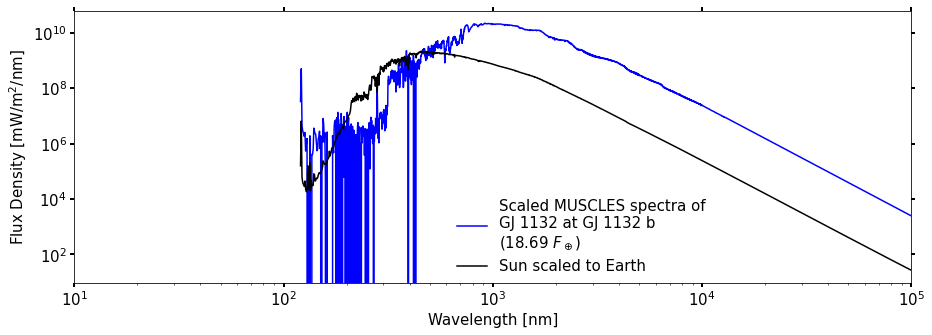

In [250]:
plt.figure(figsize = (15,5))
plt.plot(model_wavelength, Final_scaled_flux, color = 'b', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength, model_flux, color = 'k', label = 'Sun scaled to Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.45,0.01), frameon = False, fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e5)

In [251]:
#now write out the files
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    ds.ssi.values[0] = Final_scaled_flux; ds.ssi.values[1] = Final_scaled_flux
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value+'.nc'
    NewFile = NewFile.replace(" ", "_")
    ds.to_netcdf(NewFile)
    print('File saved')
elif (Climate_model_selection.value == 'ROCKE-3D'):
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value
    NewFile = NewFile.replace(" ", "_")
    df = pd.DataFrame(data={'Wavelength [m]': model_wavelength, 'Flux [W/m^3]':  Final_scaled_flux})
    df.to_csv(NewFile+'.txt', index = False)
    print('File saved')
else:
    print('File not saved')

File saved


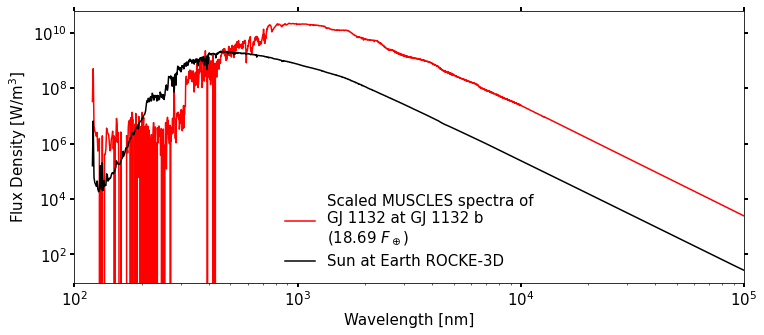

In [254]:
#rebinned spectra compared to Sun
if (Climate_model_selection.value == 'WACCM'):
    plt.figure(figsize = (12,5))
    plt.plot(model_wavelength, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(TSI_spectra/Irradiance_at_Earth,3))+' '+r'$F_\oplus$'+')')
    plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun at Earth WACCM')
    plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    plt.xlim(10,1e5)

elif(Climate_model_selection.value == 'ROCKE-3D'):
    plt.figure(figsize = (12,5))
    plt.plot(model_wavelength, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
    plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun at Earth ROCKE-3D')
    plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
    plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
    plt.ylabel('Flux Density [W/m'+sup(3)+']', fontsize = 15); plt.yscale('log')
    plt.legend(loc = 0, frameon = False, fontsize = 15)
    plt.xlim(100,1e5)
    

In [253]:
plt.figure(figsize = (15,5))
solar_file = 'TOA_Flux_at_TRAPPIST-1_b_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'grey', label = 'TRAPPIST-1 b')

solar_file = 'TOA_Flux_at_TRAPPIST-1_c_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'r', label = 'TRAPPIST-1 c')

solar_file = 'TOA_Flux_at_TRAPPIST-1_d_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'b', label = 'TRAPPIST-1 d')

solar_file = 'TOA_Flux_at_TRAPPIST-1_e_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'orange', label = 'TRAPPIST-1 e')


solar_file = 'TOA_Flux_at_TRAPPIST-1_f_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'g', label = 'TRAPPIST-1 f')


solar_file = 'TOA_Flux_at_TRAPPIST-1_g_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'm', label = 'TRAPPIST-1 g')


solar_file = 'TOA_Flux_at_TRAPPIST-1_h_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'brown', label = 'TRAPPIST-1 h')

plt.plot(model_wavelength,model_flux, color = 'k', label = 'Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.42,0.01), frameon = False, fontsize = 14, ncol = 2)
plt.ylim(1e-4,1e4)
plt.xlim(10,1e5)

FileNotFoundError: [Errno 2] No such file or directory: b'/home/jovyan/TOA_Flux_at_TRAPPIST-1_b_for_WACCM.nc'

<Figure size 1080x360 with 0 Axes>

SyntaxError: invalid decimal literal (427839947.py, line 1)